## Plot SSP5-8.5 vs SSP2-4.5

In [1]:
# Import functions
import warnings 
warnings.filterwarnings('ignore')
import os
import iris
import iris.cube
import cf_units
import numpy as np
import numpy.ma as ma
import xarray as xr
import regionmask
import iris.plot as iplt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_cm
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec

ERROR 1: PROJ: proj_create_from_database: Open of /home/h05/awells/.conda/envs/env/share/proj failed


## Load and process data

In [5]:
# file path
path = '/data/users/awells/geoMIP/processed_data/UKESM1_Annual_temp_full_'

ssp245 = xr.open_dataarray(path + 'ssp245_2020-2100.nc')
ssp585 = xr.open_dataarray(path + 'ssp585_2020-2100.nc')

Calculate end of century average and ensemble mean

In [8]:
ssp245_eoc = ssp245.sel(time=slice('2081', '2101')).mean(dim=('time', 'realization'))
ssp585_eoc = ssp585.sel(time=slice('2081', '2101')).mean(dim=('time', 'realization'))

Convert longitude

In [13]:
def adjust_longitude(dataset: xr.Dataset) -> xr.Dataset:
        """Swaps longitude coordinates from range (0, 360) to (-180, 180)
        Args:
            dataset (xr.Dataset): xarray Dataset
        Returns:
            xr.Dataset: xarray Dataset with swapped longitude dimensions
        """
        lon_name = "longitude"  # whatever name is in the data

        # Adjust lon values to make sure they are within (-180, 180)
        dataset["_longitude_adjusted"] = xr.where(
            dataset[lon_name] > 180, dataset[lon_name] - 360, dataset[lon_name])
        dataset = (
            dataset.swap_dims({lon_name: "_longitude_adjusted"})
            .sel(**{"_longitude_adjusted": sorted(dataset._longitude_adjusted)})
            .drop(lon_name)
        )

        dataset = dataset.rename({"_longitude_adjusted": lon_name})
        return dataset

ssp245_mean = adjust_longitude(ssp245_eoc)
ssp585_mean = adjust_longitude(ssp585_eoc)

## Plotting

In [10]:
params = {'legend.fontsize': 20,
          'axes.labelsize': 30,
          'axes.titlesize': 35,
          'axes.linewidth': 8,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'xtick.major.size': 8,
          'ytick.major.size': 8,
          'axes.grid': True}

plt.rcParams.update(params)

def autosize_figure(nrows, ncolumns, scale_factor=1, xscale_factor=1, yscale_factor=1):
    xwidth = (ncolumns+0.67) * 5.0 * scale_factor * xscale_factor
    ylength = (nrows+0.67) * 3.6 * scale_factor * yscale_factor
    return (xwidth, ylength)

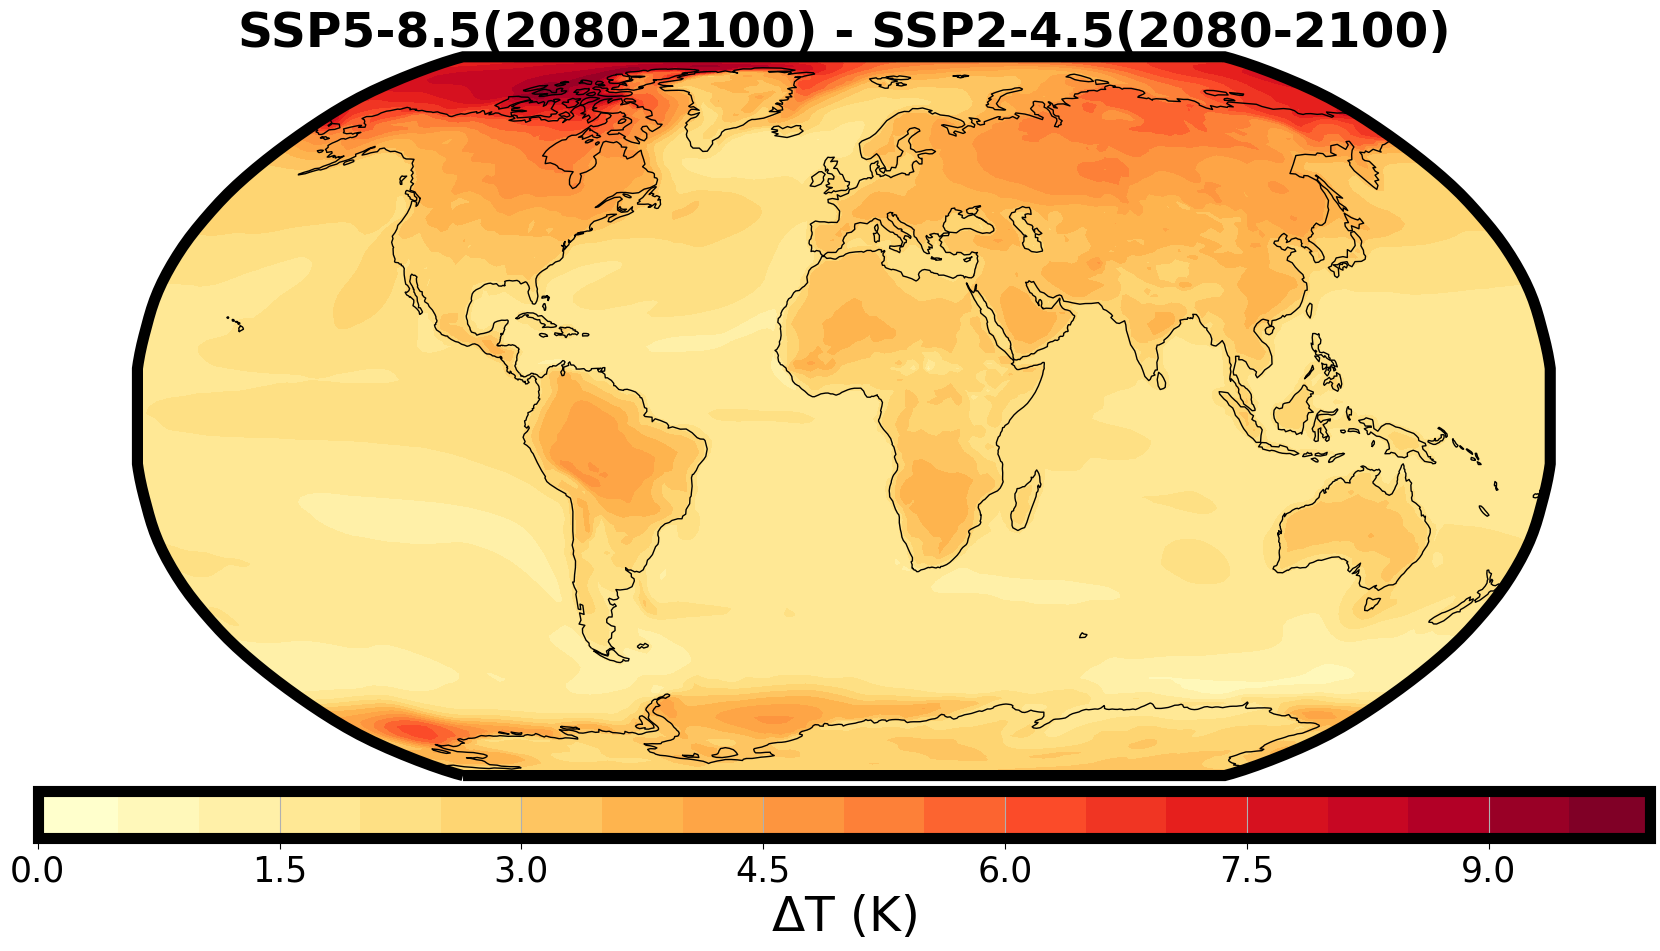

In [24]:
col_map = mpl_cm.get_cmap('YlOrRd')
projection = ccrs.Robinson()
crs = ccrs.PlateCarree()

lvs = np.linspace(0, 10, 21)

fig = plt.figure(figsize=autosize_figure(2, 1, xscale_factor=2))
gs = GridSpec(2, 1, height_ratios=[15, 1])

ax = fig.add_subplot(gs[0, 0], projection=projection, frameon=True)
cb = (ssp585_mean - ssp245_mean).plot.contourf(transform=crs, cmap=col_map, levels=lvs, add_colorbar=False, subplot_kws={'projection':projection})
ax.coastlines()
plt.title('SSP5-8.5(2080-2100) - SSP2-4.5(2080-2100)', fontweight='bold')

cax1 = fig.add_subplot(gs[1, :])
col_bar = plt.colorbar(cb, cax=cax1, orientation='horizontal')
col_bar.set_label('$\Delta$T (K)', fontsize=35)

plt.tight_layout()
plt.savefig('/net/home/h05/awells/PycharmProjects/G6_comparison/Plots/Wells2023/FigureS.png', dpi=200)
plt.show()